In [1]:
%pip install -q graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import aitk.robots
from aitk.utils import Grid
from aitk.algorithms import neat
aitk.robots.__version__

'0.9.32'

## Evolving coverage

This program uses NEAT to evolve a neural network robot controller
with a fitness function that maximizes coverage of the environment.
It uses a Grid imposed on the World to track the robot's location
over time. It uses the percentage of grid positions visited as
a fitness function.

In [3]:
world = aitk.robots.World(width=200, height=200, scale=5.0, quiet=True)
robot = aitk.robots.Scribbler(x=100, y=100, a=87, max_trace_length=60)
robot.add_device(aitk.robots.RangeSensor(position=(6,0),max=100,a=0,width=0,name="laser"))
robot.add_device(aitk.robots.RangeSensor(position=(6,-6),max=20,a=0,width=57.3,name="left-ir"))
robot.add_device(aitk.robots.RangeSensor(position=(6,6),max=20,a=0,width=57.3,name="right-ir"))
world.add_robot(robot)
world.update()
world.save()

In [4]:
world.watch(width=500)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

## Sensor inputs for achieving coverage

What are the best sensors for allowing NEAT to find good coverage solutions? Here are some options to consider:

* all or some subset of the scaled range sensors (irs and laser)
   * You may want to use 1 - scaled_value
* whether the robot is stalled 
* scaled timer (gives a sense of how long a trial will last)
  * A count down timer starts at 1.0 and decreases linearly to 0.0. 
  * A count up timer works in the reverse direction. It starts at 0.0 and increases linearly to 1.0.
* bias (some constant value)
* current coverage

Whatever sensors you choose to use you must ensure that the converage.config file is set for the appropriate number of input values.

Remember that all inputs and targets to a neural network should be scaled to match the range of the activation function. In our case, this will be tanh which has a range of [-1,1]. The range of this function allows the network's two outputs, which represent the robot's translation and rotation on each step to be both forward/backward and left/right.

In [5]:
def get_sensors(robot, max_time):
    """Currently uses 6 sensors"""
    Lir = 1.0 - robot["left-ir"].get_distance()/robot["left-ir"].get_max()
    Rir = 1.0 - robot["right-ir"].get_distance()/robot["right-ir"].get_max()
    laser = 1.0 - robot["laser"].get_distance()/robot["laser"].get_max()
    timer = 1 - robot.world.time/max_time
    stall = 0
    bias = 1.0
    if robot.stalled:
        stall = 1
    return [timer, Lir, Rir, laser, stall, bias]

## Evaluate fitness for each individual

Feed the robot's current sensor values as input to the neural network and use the output that's produced as the action to take (representing translate and rotate amounts).

In [6]:
def neat_controller(robot):
    robot.state["grid"].draw()
    robot.move(robot.state["translate"], robot.state["rotate"])

def eval_fitness(net, max_time, watch=False):
    stall_counter = 0
    robot.world.reset()
    robot.state["grid"] = Grid((10, 10), robot.world)
    robot.state["translate"] = 0
    robot.state["rotate"] = 0
    for i in range(max_time):
        x, y, direction = robot.get_pose()
        if robot.stalled:
            stall_counter += 1
        else:
            stall_counter = 0
        if stall_counter > 10:
            # end evaluation of stalled controllers
            break
        robot.state["grid"].update(x, y)
        sensor_vals = get_sensors(robot, max_time)
        output = net.activate(sensor_vals)
        robot.state["translate"] = output[0]
        robot.state["rotate"] = output[1]
        # Use the same action command for half a second
        world.steps(5,[neat_controller], real_time=False, show=watch, quiet=True)
    return robot.state["grid"].analyze_visits()

## Evaluate fitness for the entire population


In [7]:
def eval_population(pop, config):
    """This function must take these two parameters"""
    for genome_id, genome in pop:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = eval_fitness(net, 60, watch=False)

## Define how to run the evolutionary process

In [8]:
def run(config_file):
    # Load configuration
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    # Uncomment this to save checkpoints every 5 generations
    # p.add_reporter(neat.Checkpointer(5))

    winner = p.run(eval_population, 10)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))
    node_names = {-1:'d1', -2:'d2', -3:'d3', -4:'timer', 
                  -5:'stall', -6:'bias', 
                  0:'translate', 1: 'rotate'}
    neat.visualize.draw_net(config, winner, True, node_names=node_names)
    neat.visualize.plot_stats(stats, ylog=False, view=True)
    neat.visualize.plot_species(stats, view=True)
    
    return winner
    

In [9]:
%%writefile coverage.config
#--- parameters for the Robot Coverage experiment ---#

[NEAT]
fitness_criterion     = max
fitness_threshold     = 0.95
pop_size              = 50
reset_on_extinction   = False

[DefaultGenome]
# node activation options
activation_default      = tanh
activation_mutate_rate  = 0.0
activation_options      = tanh

# node aggregation options
aggregation_default     = sum
aggregation_mutate_rate = 0.0
aggregation_options     = sum

# node bias options
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1

# genome compatibility options
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.5

# connection add/remove rates
conn_add_prob           = 0.5
conn_delete_prob        = 0.5

# connection enable options
enabled_default         = True
enabled_mutate_rate     = 0.01

feed_forward            = True
initial_connection      = full

# node add/remove rates
node_add_prob           = 0.35
node_delete_prob        = 0.35

# network parameters
num_hidden              = 0
num_inputs              = 6
num_outputs             = 2

# node response options
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_max_value      = 30.0
response_min_value      = -30.0
response_mutate_power   = 0.0
response_mutate_rate    = 0.0
response_replace_rate   = 0.0

# connection weight options
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_max_value        = 30
weight_min_value        = -30
weight_mutate_power     = 0.5
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1

[DefaultSpeciesSet]
compatibility_threshold = 2.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation       = 20
species_elitism      = 1

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2

Overwriting coverage.config



 ****** Running generation 0 ****** 

Population's average fitness: 0.04940 stdev: 0.04375
Best fitness: 0.31000 - size: (2, 12) - species 2 - id 32
Average adjusted fitness: 0.039
Mean genetic distance 1.442, standard deviation 0.416
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    35      0.1    0.040     0
     2    0    15      0.3    0.039     0
Total extinctions: 0
Generation time: 6.657 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.06240 stdev: 0.05623
Best fitness: 0.31000 - size: (2, 12) - species 1 - id 32
Average adjusted fitness: 0.038
Mean genetic distance 1.369, standard deviation 0.435
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    23      0.3    0.049     0
     2    1    27      0.2    0.027     1
Total extinctions: 0
Generation time: 6.463 sec (6.560 average)

 

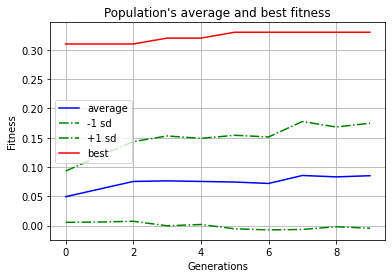

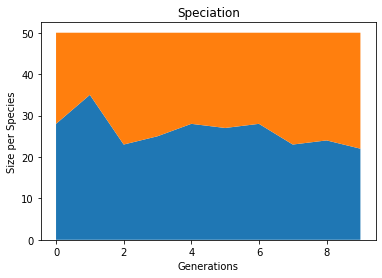

In [10]:
winner = run("coverage.config")

In [11]:
# Test the winning network
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "coverage.config")
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
eval_fitness(winner_net, 60, watch=True)

0.33

During evolution, we only allowed the robot to make 60 moves when evaluating fitness.  What happens when we allow the robot to move twice as many times?

In [12]:
eval_fitness(winner_net, 120, watch=True)

0.47

What if we go three times as long?

In [13]:
eval_fitness(winner_net, 180, watch=True)

0.49

In some evolved solutions, the fitness will increase the longer you allow the robot to move.  This is a nice result, when it happens.  It indicates that evolution has discovered a good, robust solution.  